Todo:

Write function that, given a reference set, finds the K (hyperparam) nearest neighbors in the 7d feature space and returns the average vote for those neighbors

Cross validate on val sets



Conditions
"Train" on domain, eval on same domain (try on each of the 4)
"Train" on n domains, eval on 1 (1 vs 1, 2 vs 1, 3 vs 1)

In [215]:
from collections import defaultdict
import csv
from itertools import islice, chain, combinations, permutations
from functools import reduce
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import scipy
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm_notebook
import torch
from torchvision import models, transforms, datasets

In [58]:
#NOTE: Votes are counted as [fake, real], not [incorrect, correct] !

dataset_counts = defaultdict(int)
img_counts = defaultdict(lambda : defaultdict(int))
unique_imgs = defaultdict(set)
img_votes = defaultdict(lambda: defaultdict(lambda: [0,0])) #no,yes tuples by dataset and image

with open('../../all_gans_inf.csv') as f:
    reader = csv.DictReader(f)
    for row in islice(reader, None):
        img = row['img']        
#         dataset_name = img[:img.index('/')]
        split_name = img.split('/')
        assert(len(split_name) == 2)
        dataset_name, img_name = split_name
        
        vote_index = 1 if row['correctness'] == row['realness'] else 0
        if dataset_name == 'began5000' and row['realness'] == 'True': print(row)

        img_votes[dataset_name][img_name][vote_index] += 1
        
        dataset_counts[dataset_name] += 1
        img_counts[dataset_name][img_name] += 1
unique_imgs = {dataset: len(img_counts[dataset]) for dataset in img_counts}

In [178]:
gan_models = ['progan', 'stylegan', 'began', 'wgan']

In [168]:
progan_votes = img_votes['progan5000']
began_votes = img_votes['began5000']
stylegan_votes = img_votes['styleganceleba5000']
wgan_votes = img_votes['wgangp5000']
votes = {k:v for k,v in chain(progan_votes.items(), stylegan_votes.items(), began_votes.items(), wgan_votes.items())}
len(votes)

11984

In [108]:
progan_filenames = torch.load('progan_filenames.pt', map_location=torch.device('cpu'))
progan_filenames = [os.path.split(x)[-1] for x in progan_filenames]
progan_distance_features = torch.load('progan_distance_features.pt', map_location=torch.device('cpu'))

stylegan_filenames = torch.load('stylegan_filenames.pt', map_location=torch.device('cpu'))
stylegan_filenames = [os.path.split(x)[-1] for x in stylegan_filenames]
stylegan_distance_features = torch.load('stylegan_distance_features.pt', map_location=torch.device('cpu'))

began_filenames = torch.load('began_filenames.pt', map_location=torch.device('cpu'))
began_filenames = [os.path.split(x)[-1] for x in began_filenames]
began_distance_features = torch.load('began_distance_features.pt', map_location=torch.device('cpu'))

wgan_filenames = torch.load('wgan_filenames.pt', map_location=torch.device('cpu'))
wgan_filenames = [os.path.split(x)[-1] for x in wgan_filenames]
wgan_distance_features = torch.load('wgan_distance_features.pt', map_location=torch.device('cpu'))

filenames = {'progan' : progan_filenames,
        'stylegan' : stylegan_filenames,
        'began' : began_filenames,
        'wgan' : wgan_filenames}

distance_features = {'progan' : progan_distance_features,
        'stylegan' : stylegan_distance_features,
        'began' : began_distance_features,
        'wgan' : wgan_distance_features}

In [109]:
with open('../progan_train_set.txt') as f:
    progan_train_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(progan_train_files[:5])

with open('../progan_val_set.txt') as f:
    progan_val_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(progan_val_files[:5])

with open('../stylegan_train_set.txt') as f:
    stylegan_train_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(stylegan_train_files[:5])

with open('../stylegan_val_set.txt') as f:
    stylegan_val_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(stylegan_val_files[:5])

with open('../began_train_set.txt') as f:
    began_train_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(began_train_files[:5])

with open('../began_val_set.txt') as f:
    began_val_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(began_val_files[:5])

with open('../wgan_train_set.txt') as f:
    wgan_train_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(began_train_files[:5])

with open('../wgan_val_set.txt') as f:
    wgan_val_files = [os.path.split(x.strip())[-1] for x in f.readlines()]
#print(began_val_files[:5])



with open('../progan_test_set.txt') as f:
    progan_test_files = [os.path.split(x.strip())[-1] for x in f.readlines()]

with open('../stylegan_test_set.txt') as f:
    stylegan_test_files = [os.path.split(x.strip())[-1] for x in f.readlines()]

with open('../began_test_set.txt') as f:
    began_test_files = [os.path.split(x.strip())[-1] for x in f.readlines()]

with open('../wgan_test_set.txt') as f:
    wgan_test_files = [os.path.split(x.strip())[-1] for x in f.readlines()]

train_files = {'progan' : progan_train_files,
        'stylegan' : stylegan_train_files,
        'began' : began_train_files,
        'wgan' : wgan_train_files}

val_files = {'progan' : progan_val_files,
        'stylegan' : stylegan_val_files,
        'began' : began_val_files,
        'wgan' : wgan_val_files}

test_files = {'progan' : progan_test_files,
        'stylegan' : stylegan_test_files,
        'began' : began_test_files,
        'wgan' : wgan_test_files}

In [164]:
progan_features_by_file = {progan_filenames[i] : progan_distance_features[i] for i in range(len(progan_filenames))}
print(len(progan_features_by_file))

stylegan_features_by_file = {stylegan_filenames[i] : stylegan_distance_features[i] for i in range(len(stylegan_filenames))}
print(len(stylegan_features_by_file))

began_features_by_file = {began_filenames[i] : began_distance_features[i] for i in range(len(began_filenames))}
print(len(began_features_by_file))

wgan_features_by_file = {wgan_filenames[i] : wgan_distance_features[i] for i in range(len(wgan_filenames))}
print(len(wgan_features_by_file))

# features_by_file = {'progan' : progan_features_by_file,
#         'stylegan' : stylegan_features_by_file,
#         'began' : began_features_by_file,
#         'wgan' : wgan_features_by_file}

features_by_file = {k:v for k,v in chain(progan_features_by_file.items(), stylegan_features_by_file.items(), 
                    began_features_by_file.items(), wgan_features_by_file.items())}

print(len(features_by_file))

2233
3103
1966
4251
11553


In [165]:
# progan_train_feats = np.array([features_by_file[x] for x in progan_train_files])
# print(progan_train_feats.shape)

# stylegan_train_feats = np.array([features_by_file[x] for x in stylegan_train_files])
# print(stylegan_train_feats.shape)

# began_train_feats = np.array([features_by_file[x] for x in began_train_files])
# print(began_train_feats.shape)

# wgan_train_feats = np.array([features_by_file[x] for x in wgan_train_files])
# print(wgan_train_feats.shape)

# train_feats = {'progan' : progan_train_feats,
#         'stylegan' : stylegan_train_feats,
#         'began' : began_train_feats,
#         'wgan' : wgan_train_feats}

(1787, 7)
(2483, 7)
(1574, 7)
(3401, 7)


In [189]:
dense_labels = {}
#dense_labels['val'] = {}
#dense_labels['test'] = {}

for m in gan_models:
    for val_or_test in ('val', 'test'):
        with open('../dense_labels/{}_{}_dense_labels.csv'.format(m, val_or_test)) as f:
            reader = csv.reader(f)
            for row in islice(reader,None):
                dense_labels[row[0]] = float(row[1])
                #print(row[0], float(row[1]))

len(dense_labels)

1592

In [191]:
#progan_val_files_dense = [f for f in progan_val_files if f in dense_labels]

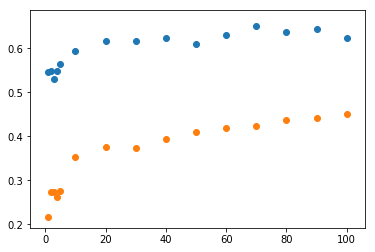

(29,
 0.6241830065359477,
 SpearmanrResult(correlation=0.4507523511961755, pvalue=2.117242100394774e-11))

In [231]:

#K = 1

#model = 'progan' #Val set from same model(s)

def knn_classify(ref_feats, x_feats, votes_by_index, k_num):
    dists = np.linalg.norm(x_feats - ref_feats, axis=1)
    
    kNN = sorted(enumerate(dists), key = lambda x: x[1])[:k_num]
    kNN_votes = reduce(lambda x, y: [x[0] + y[0], x[1] + y[1]], 
                       [votes_by_index[z[0]] for z in kNN])
    
    fake_votes, real_votes = kNN_votes
    return real_votes / (real_votes + fake_votes) # Guess of chance of "real" label
    #return real_votes >= fake_votes # Tie break by guessing "fake"


def knn_eval(train_files, eval_files, k_num):
    correct_guesses = 0
    incorrect_guesses = 0
    
    eval_predictions = []

    for x in eval_files:
        feats = features_by_file[x]

        model_votes_by_index = [votes[f] for f in train_files]
        train_features = [features_by_file[f] for f in train_files]
        pred = knn_classify(train_features, feats, model_votes_by_index, k_num)
        if x in dense_labels: eval_predictions.append(pred)

        val_fake_votes, val_real_votes = votes[x]
        
        #Binary threshold correctness here
        if pred >= 0.5:
            correct_guesses += val_real_votes
            incorrect_guesses += val_fake_votes
        else:
            correct_guesses += val_fake_votes
            incorrect_guesses += val_real_votes
    
    eval_dense_labels = [dense_labels[x] for x in eval_files if x in dense_labels]
    corr_score = scipy.stats.spearmanr(eval_predictions, eval_dense_labels)

    return correct_guesses, incorrect_guesses, corr_score 
    

def crossval_knn(train_files, val_files, test_files, try_range):
    rates = []
    corrs = []
    for k in tqdm_notebook(try_range):
        corrects, incorrects, corr = knn_eval(train_files, val_files, k)
        rates.append(corrects/(corrects+incorrects))
        corrs.append(corr)
    
    plt.scatter(try_range, rates)
    #print(len(try_range), len(corrs))
    #plt.show()
    #print(try_range)
    #print(corrs)
    plt.scatter(try_range, [corr[0] for corr in corrs])
    plt.show()
    
    best_index = np.argmax(corrs) + 1 #Using correlations instead of binary judgments for argmax! Can try both...
    
    test_corrects, test_incorrects, test_corr = knn_eval(train_files, test_files, k)
    
    return best_index, test_corrects/(test_corrects + test_incorrects), test_corr

#crossval_knn(progan_train_files, progan_val_files)
crossval_knn(progan_train_files, progan_val_files, progan_val_files, (1,2,3,4,5,10,20,30,40,50,60,70,80,90,100))

In [230]:
scipy.stats.spearmanr([1,2,3],[2,3,4])[0]

1.0

In [220]:
def general_sum(l):
    return reduce(lambda x,y: x+y, l)

one_on_ones = [(m, train_files[m], val_files[m], test_files[m]) for m in gan_models]

two_on_twos = [(m1 + ' & ' + m2, train_files[m1] + train_files[m2], val_files[m1] + val_files[m2],
               test_files[m1] + test_files[m2]) for (m1,m2) in combinations(gan_models,2)]

three_on_threes = [(m1 + ' & ' + m2 + ' & ' + m3, train_files[m1] + train_files[m2] + train_files[m3], 
                    val_files[m1] + val_files[m2] + val_files[m3],
               test_files[m1] + test_files[m2] + test_files[m3]) for (m1,m2,m3) in combinations(gan_models,3)]

all_on_all = [('All on all', general_sum([train_files[x] for x in gan_models]), 
               general_sum([val_files[x] for x in gan_models]),
               general_sum([test_files[x] for x in gan_models]))]

one_vs_ones = [('train on {}, eval on {}'.format(t,v), train_files[t], val_files[t], test_files[v]) for t,v in permutations(gan_models, 2)]
combos_to_try = general_sum([one_on_ones, two_on_twos, three_on_threes, all_on_all, one_vs_ones])

In [221]:
for description, train_set, val_set, test_set in combos_to_try:
    print(description)

progan
stylegan
began
wgan
progan & stylegan
progan & began
progan & wgan
stylegan & began
stylegan & wgan
began & wgan
progan & stylegan & began
progan & stylegan & wgan
progan & began & wgan
stylegan & began & wgan
All on all
train on progan, eval on stylegan
train on progan, eval on began
train on progan, eval on wgan
train on stylegan, eval on progan
train on stylegan, eval on began
train on stylegan, eval on wgan
train on began, eval on progan
train on began, eval on stylegan
train on began, eval on wgan
train on wgan, eval on progan
train on wgan, eval on stylegan
train on wgan, eval on began


(4, 0.6045751633986928)

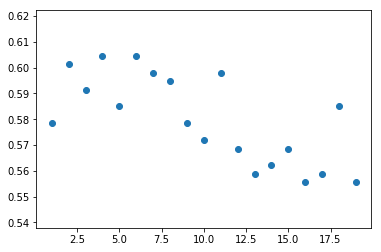

In [176]:
crossval_knn(stylegan_train_files, progan_val_files, range(1,20))

In [ ]:
progan_best_k, progan_accuracy = crossval_knn('progan')
print(progan_best_k, progan_accuracy)


77 0.6783505154639176


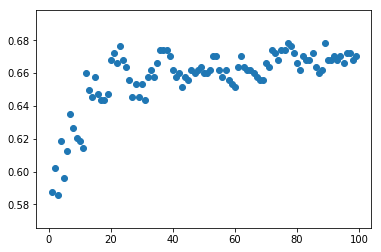

In [154]:
stylegan_best_k, stylegan_accuracy = crossval_knn('stylegan')
print(stylegan_best_k, stylegan_accuracy)


5 0.9556451612903226


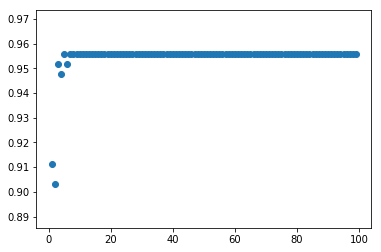

In [155]:
began_best_k, began_accuracy = crossval_knn('began')
print(began_best_k, began_accuracy)


3 0.9823008849557522


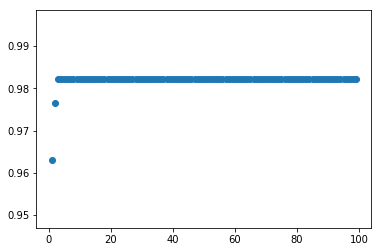

In [156]:
wgan_best_k, wgan_accuracy = crossval_knn('wgan')
print(wgan_best_k, wgan_accuracy)

Todo:
#Functionize everything, include crossval+test
#Run numbers on dense labels
#Abstract out dataset
Run on every combo of dataset